In [34]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Create output folder
import os
#output_folder = "recommendations"
output_folder = "data/daily"

os.makedirs(output_folder, exist_ok=True)

In [35]:
# URLs
URL_GAINERS = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=day_gainers&count=250"
URL_ACTIVE = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=most_actives&count=250"
URL_TRENDING = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=trending_tickers&count=250"

In [36]:
def fetch_screener(scrId, count=250): 
    url = f"https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds={scrId}&count={count}"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading screener {scrId}: {e}")


In [37]:
def fetch_trending():
    url = "https://query1.finance.yahoo.com/v1/finance/trending/US"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading trending {scrId}: {e}")

In [38]:
import re

def filter_equities(df):
    eq = []
    for s in df["symbol"]:
        if re.fullmatch(r"[A-Za-z][A-Za-z0-9\.-]{0,9}", s):
            eq.append(s)
    return pd.DataFrame({"symbol": eq})


In [39]:
print("Downloading Yahoo lists...")

df_gainers = fetch_screener("day_gainers")
df_active  = fetch_screener("most_actives")
df_trending_raw = fetch_trending()
df_trending = filter_equities(df_trending_raw)


print("Gainers:", len(df_gainers))
print("Most Active:", len(df_active))
print("Trending:", len(df_trending))

combined = pd.concat([df_gainers, df_active, df_trending], ignore_index=True)
combined.drop_duplicates(subset="symbol", inplace=True)

print("Total unique hot symbols:", len(combined))


Gainers: 117
Most Active: 250
Trending: 20
Total unique hot symbols: 336


In [40]:
def fix_num(x):
    """
    Convert Yahoo formatted numbers:
    '1.2M', '330K', '2.3B' → float
    """
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)

    x = str(x).replace(",", "")

    try:
        if x.endswith("M"):
            return float(x[:-1]) * 1e6
        if x.endswith("B"):
            return float(x[:-1]) * 1e9
        if x.endswith("K"):
            return float(x[:-1]) * 1e3
        return float(x)
    except:
        return np.nan

numeric_cols = [
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketChange",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap"
]

for col in numeric_cols:
    if col in combined.columns:
        combined[col] = combined[col].apply(fix_num)

In [41]:
df = combined.copy()

# Volume Spike Score
df["VolumeSpike"] = df["regularMarketVolume"] / df["averageDailyVolume3Month"]
df["VolumeScore"] = df["VolumeSpike"].rank(pct=True)

# Momentum Score (based on daily % change)
df["MomentumScore"] = df["regularMarketChangePercent"].rank(pct=True)

# Volatility Score (higher movement = more hot)
df["VolatilityScore"] = df["regularMarketChange"].abs().rank(pct=True)

# Trend Score (proxy: price vs avg volume)
df["TrendScore"] = (df["regularMarketPrice"] / (df["averageDailyVolume3Month"] + 1)).rank(pct=True)

# Final score
df["HotScore"] = (
    0.35 * df["MomentumScore"] +
    0.35 * df["VolumeScore"] +
    0.20 * df["VolatilityScore"] +
    0.10 * df["TrendScore"]
)

df.sort_values("HotScore", ascending=False, inplace=True)

# Keep relevant columns
output_df = df[[
    "symbol",
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap",
    "VolumeSpike",
    "MomentumScore",
    "VolumeScore",
    "VolatilityScore",
    "TrendScore",
    "HotScore"
]]

In [42]:
top50 = output_df.head(50)


timestamp = datetime.now().strftime("%Y%m%d%H%M%S") 
file_path = os.path.join(output_folder, f"hot_stocks_{timestamp}.csv")
top50.to_csv(file_path, index=False)

print("\n🔥 Saved TOP 50 hot stocks to:", file_path)
top50



🔥 Saved TOP 50 hot stocks to: data/daily\hot_stocks_20251118213253.csv


,symbol,regularMarketPrice,regularMarketChangePercent,regularMarketVolume,averageDailyVolume3Month,marketCap,VolumeSpike,MomentumScore,VolumeScore,VolatilityScore,TrendScore,HotScore
15,JAZZ,181.7300,6.843436,3216875.0,825357.0,1.104284e+10,3.897556,0.948012,0.987768,0.981651,0.984709,0.972324
16,BLTE,124.6900,6.654690,125676.0,67032.0,4.350558e+09,1.874866,0.944954,0.944954,0.963303,1.000000,0.954128
1,DGNX,16.2600,19.646800,2670666.0,767879.0,3.300868e+09,3.477978,0.996942,0.984709,0.847095,0.813456,0.944343
14,MSTR,209.6225,7.268516,17008918.0,12046590.0,6.023580e+10,1.411928,0.960245,0.905199,0.990826,0.792049,0.930275
5,AS,33.5800,9.167755,11110993.0,5230676.0,1.862251e+10,2.124198,0.984709,0.960245,0.862385,0.611621,0.914373
42,MDT,100.7551,4.648008,16929642.0,6931262.0,1.292301e+11,2.442505,0.877676,0.972477,0.923547,0.770642,0.909327
50,NTRA,214.6200,4.164241,1751121.0,1172681.0,2.962066e+10,1.493263,0.850153,0.908257,0.966361,0.981651,0.906881
2,LGN,44.9300,11.989037,1170495.0,1196474.0,6.823613e+09,0.978287,0.993884,0.761468,0.932722,0.905199,0.891437
21,GLBE,37.1700,5.806168,2177371.0,1367673.0,6.308718e+09,1.592026,0.920489,0.923547,0.787462,0.862385,0.889144
9,LQDA,30.5350,7.517607,3870860.0,2545590.0,2.656407e+09,1.520614,0.963303,0.911315,0.795107,0.737003,0.888838


In [43]:
top50['symbol']

15     JAZZ
16     BLTE
1      DGNX
14     MSTR
5        AS
42      MDT
50     NTRA
2       LGN
21     GLBE
9      LQDA
33     HTFL
23     TERN
47      MRK
53     TMDX
25     NBIS
7      SRRK
43     TIGO
63     PCAR
0      ONDS
26     ARQT
10      JHX
24     UPWK
36     CWAN
6      QUBT
19       MH
86      TFX
39     CHDN
3      WULF
32     SEDG
55     WRBY
57     CNTA
84     IRTC
60     LMND
330    BIDU
52     DECK
41     LSCC
75     WAFD
71      FCX
81     EXAS
112    PARR
28     BMNR
99     TCOM
40     TARS
27     CGON
142     LNW
105     ALB
35     IREN
17     EOSE
77     NFLX
59      HUT
Name: symbol, dtype: object

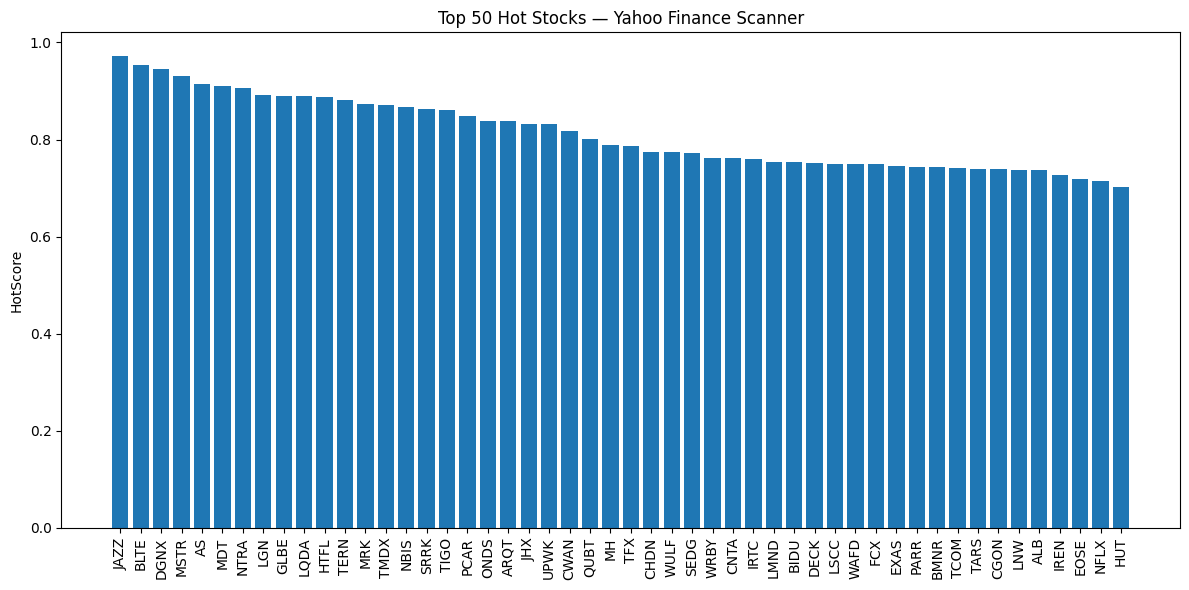

In [44]:

# --------------------------------------------------------
# 6. Plot Heat Bar
# --------------------------------------------------------

plt.figure(figsize=(12, 6))
plt.bar(top50["symbol"], top50["HotScore"])
plt.xticks(rotation=90)
plt.title("Top 50 Hot Stocks — Yahoo Finance Scanner")
plt.ylabel("HotScore")
plt.tight_layout()
plt.show()